In [45]:
import faces
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mrcnn.model as modellib
import mrcnn.visualize as visualize
import mrcnn.config as config
import mrcnn.utils as utils
from matplotlib import image

In [4]:
Faces_config = faces.FacesConfig()
Infer_config = faces.FacesInferConfig()

In [5]:
images_list = os.listdir(faces.DATASET_PATH)

random.seed(42)
random.shuffle(images_list)
val_size = 30

images_val = images_list[:val_size]
images_train = images_list[val_size:]
print(len(images_train), len(images_val))

70 30


In [6]:
# Training set
fp = os.path.join(faces.ANNOTS_PATH, 'polygons_100.json')
dataset_train = faces.FacesDataset(images_train, fp, faces.DATASET_PATH)
dataset_train.prepare()

In [7]:
# Validation set
dataset_val = faces.FacesDataset(images_val, fp, faces.DATASET_PATH)
dataset_val.prepare()

In [8]:
# Inference Model
weights_path = os.path.abspath('./models/faces20220829T2146/mask_rcnn_faces_0009.h5')

model_infer = faces.load_inference(Infer_config)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 9


In [9]:
def get_ax(rows=1, cols=1, size=12):
    _, ax  = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [16]:
image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
  modellib.load_image_gt(dataset_val, Infer_config, image_id, use_mini_mask=True)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info['source'], info['id'], image_id,
                                        dataset_val.image_reference(image_id)))

output = model_infer.detect([image], verbose=1)
results = output[0]
print("Dictionary Keys", results.keys(), end='\n\n')
print("Bounding Boxes:\n", results['rois'], end='\n\n')
print("Class IDs:\n", np.array(dataset_val.class_names)[results['class_ids']], end="\n\n")
print("Prediction Scores:\n", results['scores'], end="\n\n")

image ID: Faces.66 (4) None
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32
Dictionary Keys dict_keys(['rois', 'class_ids', 'scores', 'masks'])

Bounding Boxes:
 [[123  96 174 126]
 [180  91 202 136]]

Class IDs:
 ['nose' 'mouth']

Prediction Scores:
 [0.99991786 0.99948347]



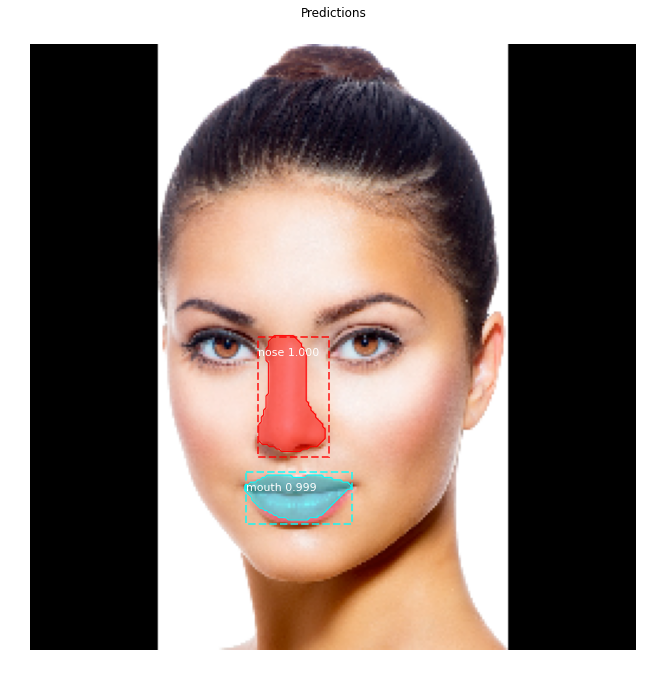

In [17]:
ax = get_ax(1)
r = results

x = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=ax,
                            title = 'Predictions')

In [19]:
import cv2 as cv

In [62]:
def get_masked_image(image, result):
    """
    Applies masks from the results to the given image
  
    """
    boxes = result['rois']
    masks = result['masks']
  
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")

    colors = visualize.random_colors(N)
    masked_image = image.astype(np.uint32).copy()

    for i in range(N):
        color = colors[i]

        # Mask
        mask = masks[:, :, i]
        masked_image = visualize.apply_mask(masked_image, mask, color)
    return masked_image.astype(np.uint8)

In [72]:
class VideoInferConfig(config.Config):

    NAME = "Faces"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = 448
    IMAGE_MAX_DIM = 640
    
    NUM_CLASSES = 4

    LEARNING_RATE = 0.001
    STEPS_PER_EPOCH = 500

In [73]:
vid_config = VideoInferConfig()
model_vid = faces.load_inference(vid_config)

Re-starting from epoch 9


In [79]:
cap = cv.VideoCapture(0, cv.CAP_DSHOW)
w = 600
h = 400
cap.set(3,w)
cap.set(4,h)

frames = []
frame_count = 0

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("Ignoring Empty camera frame")
        break
    #frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        
    frame_count += 1
    frames.append(frame)
    if len(frames) == 1:
        predictions = model_vid.detect(frames, verbose=0)
        #print("Predicted")
        for i, item in enumerate(zip(frames, predictions)):
            frame = item[0]
            p = item[1]
            frame = get_masked_image(frame, p)
            cv.imshow('Scan', frame)
            frames = []

    if cv.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()
cv.waitKey(1)

-1

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


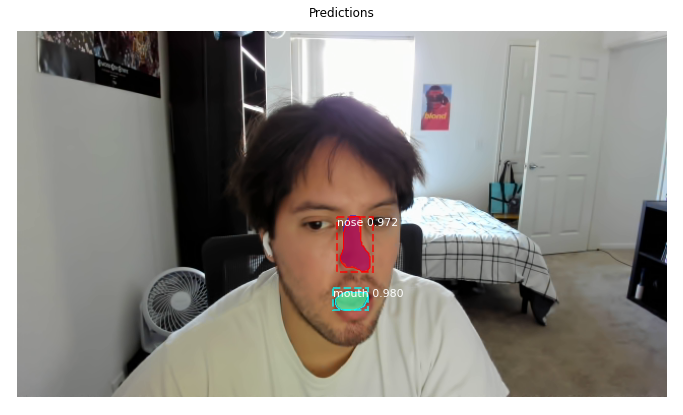

In [81]:
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
pred = model_vid.detect([frame], verbose=1)
ax = get_ax(1)
r = pred[0]

visualize.display_instances(frame, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=ax,
                            title = 'Predictions')